In [4]:
# Step 1: Required Packages
!pip install -q onnx onnxruntime

# Step 2: Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import onnx
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Dataset Load and Normalization
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

train_size = int(0.67 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128)

# Step 4: CNN Model
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3),        # -> (26, 26, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),            # -> (13, 13, 32)
            nn.Conv2d(32, 64, 3),       # -> (11, 11, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),            # -> (5, 5, 64)
            nn.Flatten(),               # -> (1600)
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)          # -> Output logits
        )

    def forward(self, x):
        return self.network(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitClassifier().to(device)

# Step 5: Training Parameters
loss_fn = nn.CrossEntropyLoss()
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Step 6: Training Loop with Scheduler
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step()  # Learning rate updated every epoch
    print(f"Epoch {epoch+1}: LR={scheduler.get_last_lr()[0]:.5f} | Train Loss={train_loss:.4f}, Acc={train_acc:.3f} | Val Loss={val_loss:.4f}, Acc={val_acc:.3f}")


Epoch 1: LR=0.00100 | Train Loss=0.4530, Acc=0.860 | Val Loss=0.1081, Acc=0.967
Epoch 2: LR=0.00100 | Train Loss=0.1379, Acc=0.960 | Val Loss=0.0704, Acc=0.979
Epoch 3: LR=0.00100 | Train Loss=0.1004, Acc=0.970 | Val Loss=0.0599, Acc=0.982
Epoch 4: LR=0.00100 | Train Loss=0.0819, Acc=0.976 | Val Loss=0.0507, Acc=0.985
Epoch 5: LR=0.00050 | Train Loss=0.0700, Acc=0.979 | Val Loss=0.0464, Acc=0.987
Epoch 6: LR=0.00050 | Train Loss=0.0552, Acc=0.984 | Val Loss=0.0407, Acc=0.988
Epoch 7: LR=0.00050 | Train Loss=0.0484, Acc=0.986 | Val Loss=0.0418, Acc=0.988
Epoch 8: LR=0.00050 | Train Loss=0.0458, Acc=0.986 | Val Loss=0.0411, Acc=0.988
Epoch 9: LR=0.00050 | Train Loss=0.0416, Acc=0.987 | Val Loss=0.0404, Acc=0.989
Epoch 10: LR=0.00025 | Train Loss=0.0387, Acc=0.988 | Val Loss=0.0410, Acc=0.989
Epoch 11: LR=0.00025 | Train Loss=0.0350, Acc=0.989 | Val Loss=0.0387, Acc=0.990
Epoch 12: LR=0.00025 | Train Loss=0.0308, Acc=0.991 | Val Loss=0.0387, Acc=0.990
Epoch 13: LR=0.00025 | Train Loss=0.0

In [5]:
#Step 7: Exporting Model to ONNX Format ---
dummy_input = torch.randn(1, 1, 28, 28).to(device)
onnx_file = "mnist_cnn_model.onnx"
torch.onnx.export(model, dummy_input, onnx_file, input_names=["input"], output_names=["output"], opset_version=11)
print(f"Saved model to: {onnx_file}")


Saved model to: mnist_cnn_model.onnx


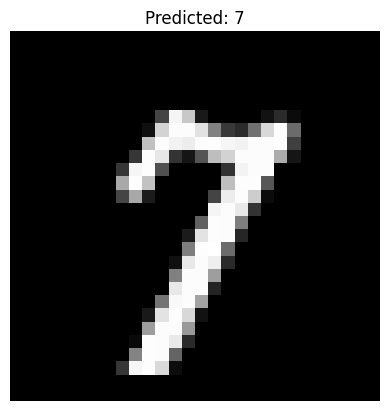

In [6]:
#Step 8: Loading and Test ONNX Model on Random Samples ---
# Loading the ONNX model
onnx_session = ort.InferenceSession(onnx_file)
input_name = onnx_session.get_inputs()[0].name

# test data and run prediction
sample_images, sample_labels = next(iter(val_loader))
sample_image = sample_images[0:1].numpy()

# ONNX expects float32
input_tensor = sample_image.astype(np.float32)
onnx_output = onnx_session.run(None, {input_name: input_tensor})[0]
predicted_label = np.argmax(onnx_output)

# Displaying the image and prediction
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()
